In [ ]:
import sys; sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt

from common.polymarket import fetch_event, filter_markets_by_volume, fetch_price_history

In [ ]:
EVENT_ID = 903193  # 2024 US Presidential Election

event = fetch_event(EVENT_ID)

print(f"Event: {event['title']}")
print(f"Total markets: {len(event['markets'])}")
print(f"Event period: {event['startDate']} → {event['endDate']}")


Event: Presidential Election Winner 2024
Total markets: 17
Event period: 2024-01-04T22:58:00Z → 2024-11-05T12:00:00Z


In [ ]:
filtered_markets = filter_markets_by_volume(event, threshold_pct=0.05)

print(f"Filtered to {len(filtered_markets)} markets (>5% volume):\n")
for m in filtered_markets:
    print(f"{m['question'][:60]}")
    print(f"  Volume: ${m['volume']:,.0f}\n")

Filtered to 3 markets (>5% volume):

Will Donald Trump win the 2024 US Presidential Election?
  Volume: $1,531,479,285

Will Kamala Harris win the 2024 US Presidential Election?
  Volume: $1,037,039,118

Will any other Republican Politician win the 2024 US Preside
  Volume: $241,655,100



In [12]:
start_date = pd.to_datetime(event['startDate'], utc=True)
end_date = pd.to_datetime(event['endDate'], utc=True)

all_market_data = {}

for market in filtered_markets:
    data = fetch_price_history(market['token_id'], start_date, end_date)
    all_market_data[market['question']] = data
    print(f"{market['question'][:50]}: {len(data['times'])} points")

Will Donald Trump win the 2024 US Presidential Ele: 439803 points
Will Kamala Harris win the 2024 US Presidential El: 439715 points
Will any other Republican Politician win the 2024 : 437120 points


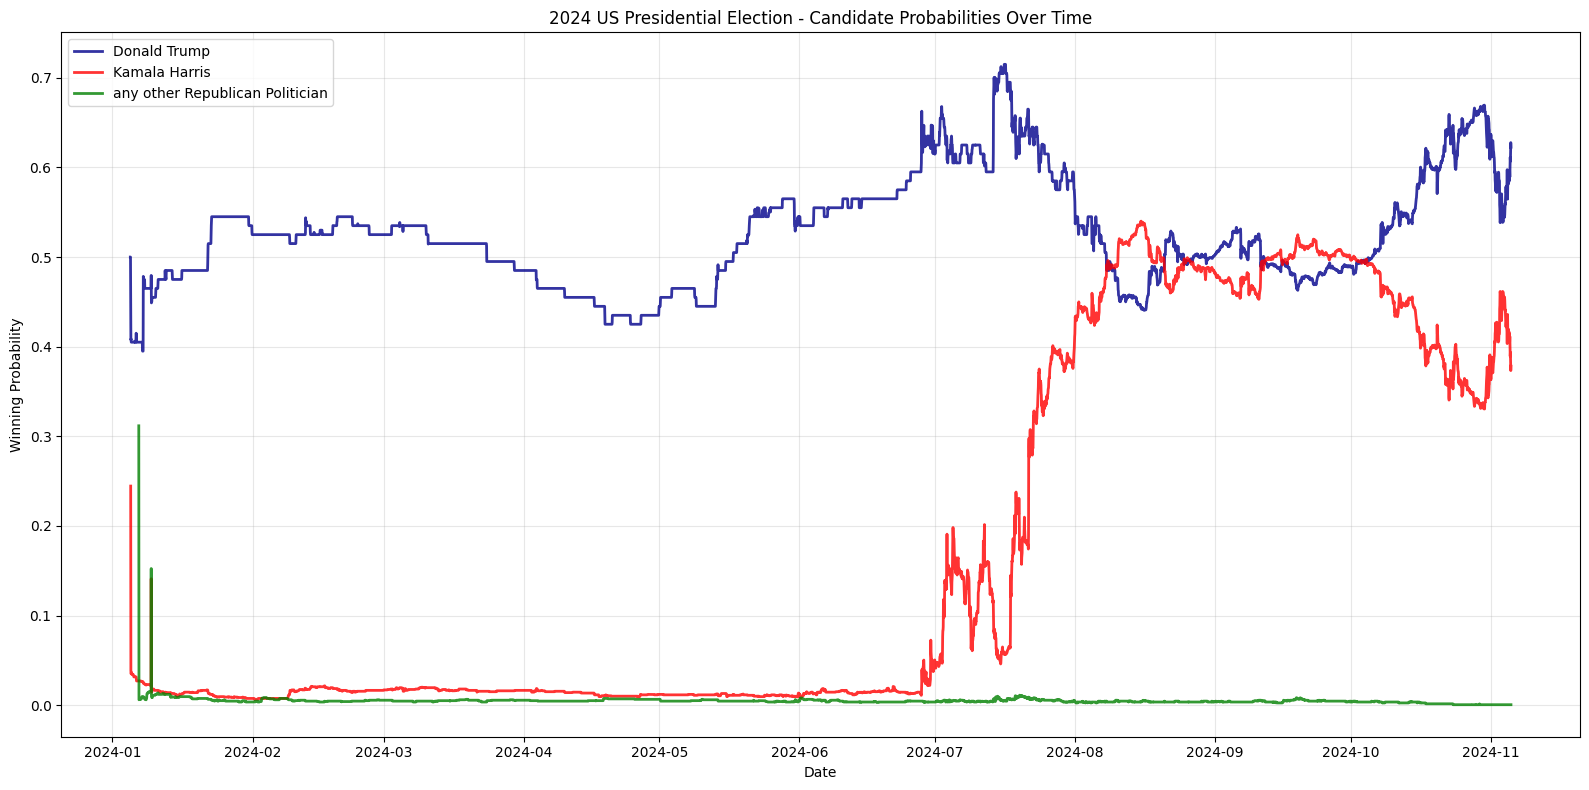

In [13]:
plt.figure(figsize=(16, 8))

colors = ['darkblue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, (question, data) in enumerate(all_market_data.items()):
    if len(data['times']) > 0:
        df_temp = pd.DataFrame({'time': data['times'], 'price': data['prices']})
        df_temp['hour'] = df_temp['time'].dt.floor('h')
        hourly = df_temp.groupby('hour')['price'].mean()
        
        candidate = question.split('Will ')[-1].split(' win')[0] if 'Will' in question else question[:20]
        
        plt.plot(hourly.index, hourly.values, linewidth=2, label=candidate, color=colors[idx % len(colors)], alpha=0.8)


plt.xlabel('Date')
plt.ylabel('Winning Probability')
plt.title('2024 US Presidential Election - Candidate Probabilities Over Time')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import json

data_to_save = {
    'event': {
        'id': EVENT_ID,
        'title': event['title'],
        'start_date': start_date.isoformat(),
        'end_date': end_date.isoformat(),
    },
    'markets': filtered_markets,
    'price_data': {
        question: {
            'times': [t.isoformat() for t in data['times']],
            'prices': data['prices']
        }
        for question, data in all_market_data.items()
    }
}

with open('../data/election_2024_prices.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)

print(f"Saved to ../data/election_2024_prices.json")
print(f"  Event: {event['title']}")
print(f"  Markets: {len(filtered_markets)}")
print(f"  Data points: {sum(len(d['times']) for d in all_market_data.values()):,}")

Saved to ../data/election_2024_prices.json
  Event: Presidential Election Winner 2024
  Markets: 3
  Data points: 1,316,638
